# Proyek Klasifikasi Gambar: Retinal Optical Coherence Tomography (OCT)
- **Nama:** Luigi Ifan Dwiutomo
- **Email:** luigiifan@student.ppns.ac.id
- **ID Dicoding:** luigiifan13

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install tensorflowjs

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import random
from glob import glob
import tensorflow as tf
import tensorflowjs as tfjs
from IPython.display import FileLink
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,Input,concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

2025-04-27 06:44:51.401947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745736291.600487      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745736291.655065      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preparation

### Data Loading

In [3]:
# Main Folder Path
folder_path = "/kaggle/input/kermany2018/OCT2017 "

# Sub Folder Paths
train_dir = f"{folder_path}/train"
val_dir = f"{folder_path}/val"
test_dir = f"{folder_path}/test"

In [4]:
print(f"Train Directory: {os.listdir(train_dir)}")
print(f"Validation Directory: {os.listdir(test_dir)}")
print(f"Test Directory: {os.listdir(val_dir)}")

Train Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Validation Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Test Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']


**Insight:**:
- Dataset terlabel yang digunakan sudah di split menjadi train, val, dan test dari sumber.
- Terdapat 4 classes yakni DRUSEN, CNV, NORMAL dan DME.

### Data Preprocessing

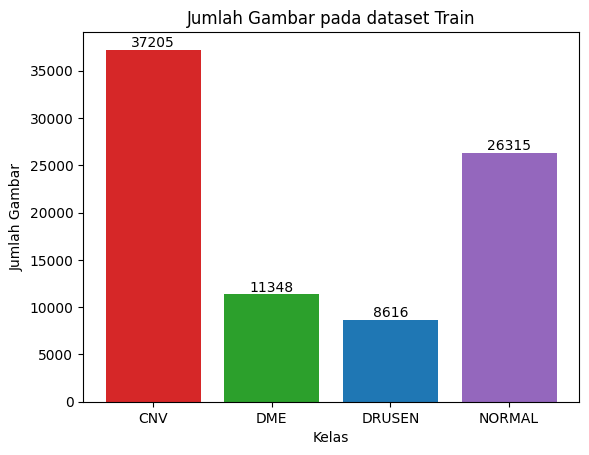

In [5]:
train_data_path = train_dir

image_counts = {
    "CNV": 0,
    "DME": 0,
    "DRUSEN": 0,
    "NORMAL": 0
}

for class_label in image_counts:
    class_folder = os.path.join(train_data_path, class_label)
    image_counts[class_label] = len([img for img in os.listdir(class_folder)])

labels = list(image_counts.keys())
values = list(image_counts.values())

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['tab:red', 'tab:green', 'tab:blue', 'tab:purple'])
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, round(height), ha='center', va='bottom')

ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Gambar')
ax.set_title('Jumlah Gambar pada dataset Train')
plt.show()

**Insight:**:
- Jumlah dataset Train berjumlah 83,484 gambar.
- Terdiri dari 4 classes: CNV, DME, DRUSEN dan NORMAL.

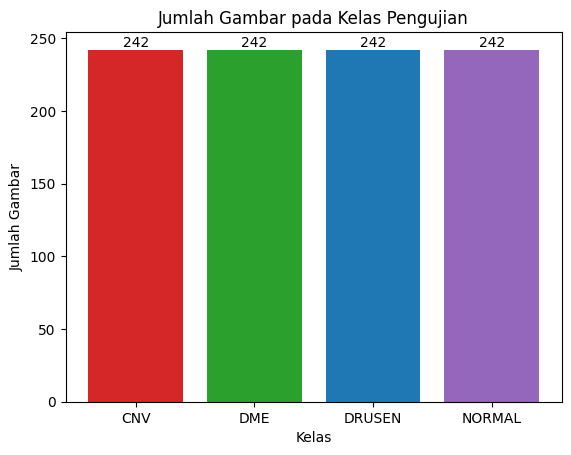

In [6]:
test_data_path = test_dir

image_counts = {
    "CNV": 0,
    "DME": 0,
    "DRUSEN": 0,
    "NORMAL": 0
}

for class_label in image_counts:
    folder_path = os.path.join(test_data_path, class_label)
    image_counts[class_label] = len(os.listdir(folder_path))

class_names = list(image_counts.keys())
image_numbers = list(image_counts.values())

fig, ax = plt.subplots()
bars = ax.bar(class_names, image_numbers, color=['tab:red', 'tab:green', 'tab:blue', 'tab:purple'])
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, round(height), ha='center', va='bottom')


ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Gambar')
ax.set_title('Jumlah Gambar pada Kelas Pengujian')
plt.show()

**Insight:**:
- Jumlah dataset pada Test yakni 968 gambar dari setiap classes.

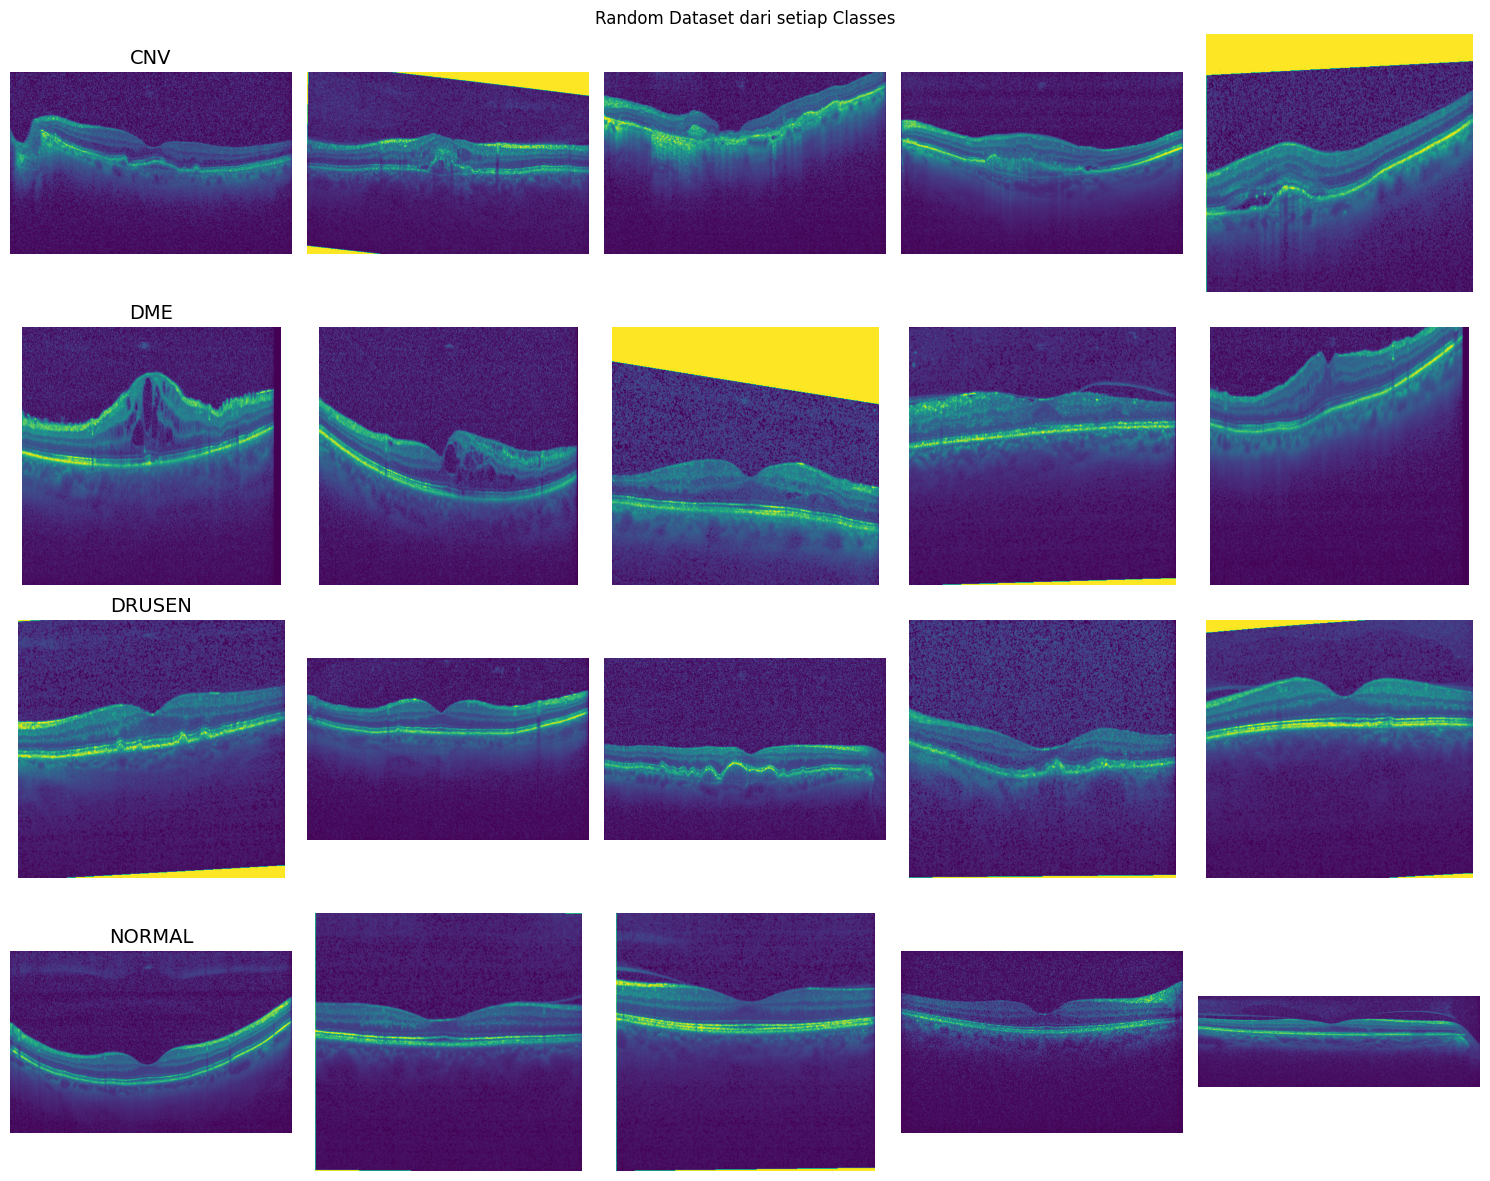

In [7]:
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

# Load and display 6 random examples from each class
fig, axs = plt.subplots(4, 5, figsize=(15, 12))
for i, class_name in enumerate(classes):
    class_images = os.listdir(os.path.join(train_dir, class_name))
    selected_images = random.sample(class_images, 5)

    for j, img_name in enumerate(selected_images):
        image_path = os.path.join(train_dir, class_name, img_name)
        img = imread(image_path)
        
        # Display on the appropriate subplot
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        
    axs[i, 0].set_title(f"{class_name}", fontsize=14)
plt.suptitle("Random Dataset dari setiap Classes")
plt.tight_layout()
plt.show()

## Modelling

In [8]:
batch_size = 32
image_shape = (299,299,1)
datagen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.20,
                               height_shift_range=0.15,
                               rescale=1/255,
                               shear_range=0.15,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               validation_split = 0.2
                              )
valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [9]:
train_generator = datagen.flow_from_directory(train_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=True)

Found 83484 images belonging to 4 classes.


In [10]:
valid_generator = valid_datagen.flow_from_directory(val_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=False)

Found 32 images belonging to 4 classes.


In [11]:
test_generator = valid_datagen.flow_from_directory(test_dir,
                                               target_size=(299,299),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical', shuffle=False)

Found 968 images belonging to 4 classes.


In [12]:
model = Sequential([
    Input(shape=image_shape),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

I0000 00:00:1745736419.435044      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 299, 299, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 149, 149, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 87616)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       5,607,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,682,244 (21.68 MB)

 Trainable params: 5,682,244 (21.68 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

In [15]:
results = model.fit(train_generator,epochs=10, validation_data=valid_generator, callbacks=[early_stop])

Epoch 1/10


I0000 00:00:1745736426.918570     124 service.cc:148] XLA service 0x781954006e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745736426.919441     124 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745736427.201927     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2609 ━━━━━━━━━━━━━━━━━━━━ 2:26 56ms/step - accuracy: 0.2266 - loss: 1.6867  

I0000 00:00:1745736432.602630     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1156s 439ms/step - accuracy: 0.6026 - loss: 0.9779 - val_accuracy: 0.6562 - val_loss: 0.8454
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 727s 278ms/step - accuracy: 0.7608 - loss: 0.6346 - val_accuracy: 0.6250 - val_loss: 0.9865
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 718s 274ms/step - accuracy: 0.7963 - loss: 0.5513 - val_accuracy: 0.7500 - val_loss: 0.9582
Epoch 4/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 709s 271ms/step - accuracy: 0.8249 - loss: 0.4818 - val_accuracy: 0.8125 - val_loss: 0.6612
Epoch 5/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 715s 273ms/step - accuracy: 0.8413 - loss: 0.4387 - val_accuracy: 0.8125 - val_loss: 0.5779
Epoch 6/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 716s 274ms/step - accuracy: 0.8572 - loss: 0.3948 - val_accuracy: 0.7812 - val_loss: 0.4672
Epoch 7/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 710s 272ms/step - accuracy: 0.8690 - loss: 0.3722 - val_accuracy: 0.8750 - val_loss: 0.3450
Epoch 8/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 714s 273ms/step - accuracy: 0.

**Insight**:
- Menerapkan data augmentation seperti rotasi, pergeseran (horizontal dan vertikal), zoom, flip horizontal, rescaling, shearing dan split data pelatihan menjadi dua bagian 80% untuk pelatihan dan 20% validasi.
- Data diubah ukuran target gambarnya ke 299x299 untuk input model dan batch size diatur sebesar 32.
- Menerapkan fungsi callback EarlyStopping untuk menghentikan pelatihan model otomatis ketika val_loss tidak ada peningkatan selama 10 epoch.

## Evaluasi dan Visualisasi

In [19]:
# Menampilkan akurasi pelatihan dan validasi
print("Akurasi pada data pelatihan:")
print("Training Accuracy:", results.history['accuracy'])

print("Akurasi pada data validasi:")
print("Validation Accuracy:", results.history['val_accuracy'])

Akurasi pada data pelatihan:
Training Accuracy: [0.6886349320411682, 0.771573007106781, 0.8039265275001526, 0.8292607069015503, 0.8459465503692627, 0.8603684306144714, 0.8722869157791138, 0.8822169303894043, 0.8879905343055725, 0.8949379324913025]
Akurasi pada data validasi:
Validation Accuracy: [0.65625, 0.625, 0.75, 0.8125, 0.8125, 0.78125, 0.875, 0.875, 0.9375, 0.9375]


In [16]:
loss, acc = model.evaluate(test_generator)
print(f"Akurasi Test: {acc*100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.9422 - loss: 0.1789
Akurasi Test: 93.90%


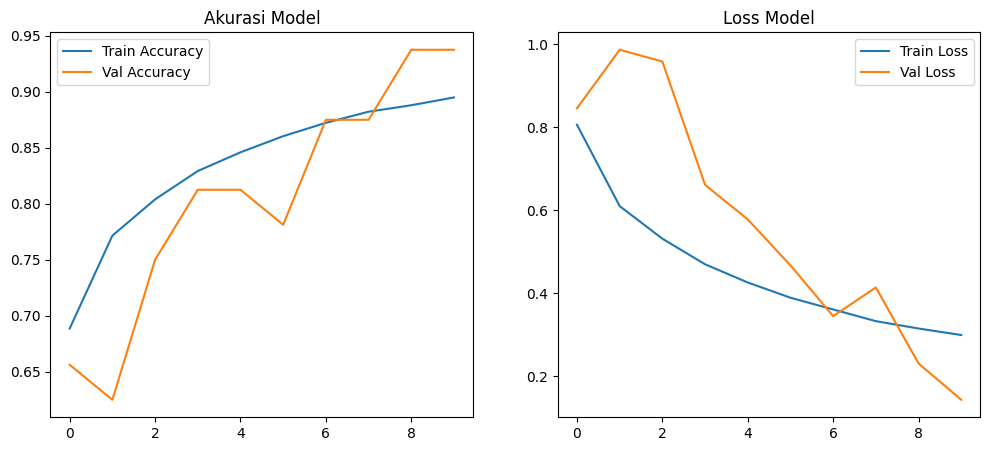

In [17]:
# Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Akurasi Model')

# Loss
plt.subplot(1, 2, 2)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Model')

plt.show()

**Insight:**:
- Didapatkan akurasi dari pelatihan model mencapai 89.5%.
- Hasil evaluasi kinerja model setelah pelatihan pada data uji didapatkan akurasi sekitar 94%.

## Konversi Model

In [18]:
# SavedModel
model.export('/kaggle/working/saved_model')

# TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('/kaggle/working/saved_model')
tflite_model = converter.convert()
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

# TFJS
tfjs.converters.save_keras_model(model, '/kaggle/working/tfjs_model')

Saved artifact at '/kaggle/working/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132054012928144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132054010244048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132054010245008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132054010245584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132054010244624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132054010245968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132054010246160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132054010246736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132054010246928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132054010247888: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1745744025.891364      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745744025.891404      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1745744025.899717      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


failed to lookup keras version from the file,
    this is likely a weight only file


**Insight:**
- Model disimpan dalam format SavedModel, TFLite, dan TFJS.